# Preprocesamiento para Experimentos de Actividad Espontánea
 
Este Cuaderno es muy similar al Preprocesamiento para Evocados, pero sin promediar sobre múltiples estímulos. 
Dado que estos experimentos son muy grandes y causan problemas con el RAM, lo que vamos a hacer es primero cortarlos en cachos 
manejables (aproximadamente unos 400MB a lo más), y hacer el preprocesamiento sobre cada subarchivo.
En lugar de eso se recomienda una inspección visual para obtener un intervalo interesante del Archivo Experimental.

In [10]:
push!(LOAD_PATH, ".")
using SeparaActividadySaturados01
using HDF5, PyPlot, Statistics

┌ Info: Precompiling SeparaActividadySaturados01 [top-level]
└ @ Base loading.jl:1186


La mayoría de los experimentos de actividad espontánea producen archivos de varios GB. Es imposible hacer el prerprocesamiento con 
memoría limitada. Es muy probable que haya que dividir el archivo en cachos.

In [11]:
abrestring="/home/karel/BRWFiles/estriado/estriado_slice1_1004AP.brw"
stringgeneral=replace(abrestring, ".brw"=>"")  

"/home/karel/BRWFiles/estriado/estriado_slice1_1004AP"

In [12]:
a=h5open(abrestring);
names(a)

3-element Array{String,1}:
 "3BData"    
 "3BRecInfo" 
 "3BUserInfo"

In [13]:
names(a["3BUserInfo"])

2-element Array{String,1}:
 "ExpMarkers"
 "ExpNotes"  

In [14]:
bla=read(a["3BUserInfo"]["ExpNotes"])

1-element Array{HDF5.HDF5Compound{2},1}:
 HDF5.HDF5Compound{2}(("\xb0\x91\xd0\x03", "\x90\x8a\xc6\x03"), ("Title", "Value"), (String, String))

In [15]:
tamax=400*1024*1024  #maximo tamaño tolerable de archivo
tam=filesize(abrestring)
cachos=div(tam,tamax)+1

11

In [16]:
Datos=AbreyCheca(abrestring)

Dict{String,Any} with 8 entries:
  "minvolt"     => -4125.0
  "maxvolt"     => 4125.0
  "frecuencia"  => 17855.5
  "DatosCrudos" => UInt16[0x0000, 0x07f6, 0x080c, 0x07fe, 0x07f6, 0x07f6, 0x07f…
  "bitdepth"    => 0x0c
  "factor"      => 2.01416
  "numcuadros"  => 535665
  "duracion"    => 30.0

In [17]:
### parametetros globales.
freq=Datos["frecuencia"]/1000 #cuadros por milisegundo.
factor=Datos["factor"] #Factor de conversion de numeros enteros a microVolts
retrazo=round(Int, ceil(5*freq))
final=round(Int, ceil(60*freq))
latencia=round(Int, ceil(1.5*freq))


27

In [18]:
cuadrosmax=Datos["numcuadros"]
tiempototalms=round(cuadrosmax/freq; digits=1) 
println("Tienes ", cuadrosmax, " cuadros de muestreo a ", round(freq; digits=4), " cuadros por milisegundo")
println( "Esto corresponde a  ", tiempototalms, "ms." )

Tienes 535665 cuadros de muestreo a 17.8555 cuadros por milisegundo
Esto corresponde a  30000.0ms.


In [19]:
fmemlibre=Sys.free_memory()/Sys.total_memory()

0.45773974289170566

In [20]:
# Si los datos andan en un arreglo de lista en lugar de cuadrado, los ponemos cuadrados
if size(Datos["DatosCrudos"])[1] != 4096
DatosCrudosArreglados=reshape(Datos["DatosCrudos"], (4096, Datos["numcuadros"]))
else
DatosCrudosArreglados=Datos["DatosCrudos"]
end;

In [75]:
size(DatosCrudosArreglados)
DatosCrudosArreglados[70, 10:20]

11-element Array{UInt16,1}:
 0x07ff
 0x07f8
 0x0809
 0x0801
 0x0800
 0x07ef
 0x0803
 0x07f8
 0x0800
 0x0800
 0x0815

In [22]:
bla2(j,k)=64*(j-1)+k
bla2(33,48)


2096

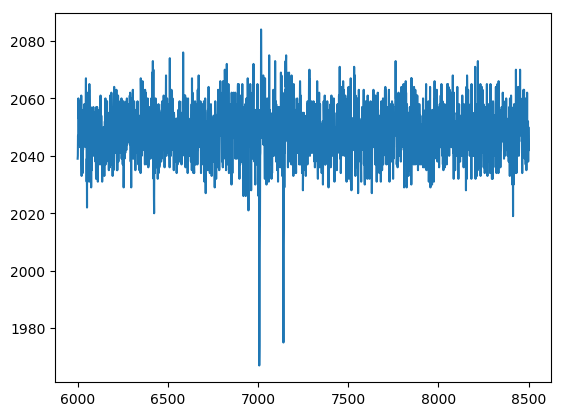

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fbbc81819e8>

In [23]:
rango=6000:8500
plot(rango, vec(DatosCrudosArreglados[2096,rango]))

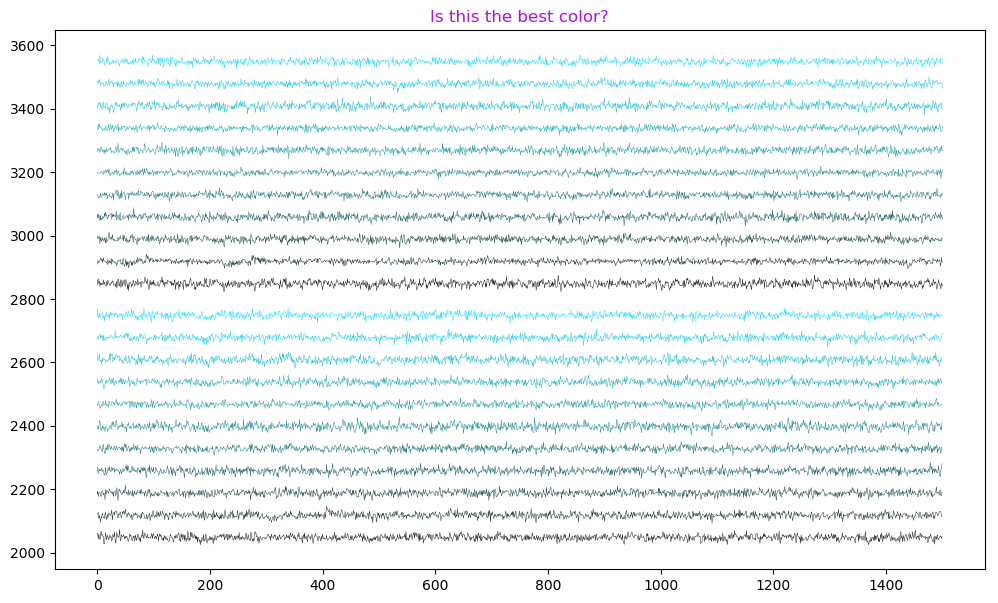

In [24]:
figure(figsize=(12,7))

title("Is this the best color?", color="#af0eee")

jmax=10

for j=0:jmax
    k=j*64+3
    plot(DatosCrudosArreglados[k,1:1500].+70*j, lw=0.3, color=(0,sin(j/jmax),j/jmax))
end


for j=0:10
    k=j*64+3
    plot(DatosCrudosArreglados[k,52000:53500].+(800+70*j), lw=0.3, color=(0,sin(j/jmax),j/jmax))
end



In [25]:
DatosCrudosArreglados[1,1]==0

true

In [26]:
cachos

11

In [27]:
# si la fraccion de memoria libre es inferior a 0.2, tenemos que cortar un cacho de los datos. Que tan chico el cacho depende... 
# toca probar
if cachos > 1
    ## escoga el usuario un cacho para trabajar entre 1 y cachos
    cacho=1
    pedazo=round(Int, Datos["numcuadros"]/cachos)
    if cacho < cachos # si no es el ultimo cacho
     DatosCrudosArreglados=DatosCrudosArreglados[:,(1+(cacho-1)*pedazo):cacho*pedazo]
    else
     DatosCrudosArreglados=DatosCrudosArreglados[:,(1+(cacho-1))*pedazo:cuadrosmax]
    end
    palabritaespecial="/Cacho_$(cacho)_"
else
    palabritaespecial="/Completo_"
end

#    end;
# Liberar memoria
#Datos["DatosCrudos"]=0
println( "Este será el identificador del archivo en cachos: ", palabritaespecial)


Este será el identificador del archivo en cachos: /Cacho_1_


In [28]:
size(DatosCrudosArreglados)

(4096, 48697)

In [29]:
 DatosCentrados=FormaMatrizDatosCentrados(DatosCrudosArreglados, factor);
# libera memoria
#DatosCrudosArreglados=0

In [30]:
ncuadros=size(DatosCentrados)[3]

48697

In [31]:
extrema(DatosCentrados)

(-4125.0, 4122.98583984375)

In [70]:

function BCRP(datos::Array,freq::Number, tini=0.5,
                              tfin=8,
                              maxvolt=-100, minvolt=-1500, 
        minstd=10, maxstd=35)
    #Busquemos los canales con probable respuesta de potencial de accion
    (ancho,alto,largo)=size(datos)
    cini=round(Int, ceil(tini*freq))

    taux1=round(Int, ceil(tini*freq))
    taux2=round(Int,ceil(tfin*freq))
    
    println("Estoy buscando del cuadro " , taux1, " al , ", taux2)
    
    result=[0::Int64 0::Int64 ]
    for j=1:ancho, k=1:alto
        fondo=minimum(vec(datos[k,j,taux1:taux2]))
        dpgs=std(datos[k,j,taux1:taux2])

        if  (maxvolt >fondo>minvolt) && ( maxstd > dpgs > minstd)
            print(dpgs, " ")
            bla=[k j]
            result=vcat(result,bla)
        end
    end

    #= Esta rutina no es muy confiable. Solo da buenos resultados
    con actividad evocada. Necesitamos algo mas estricto =#
   
    return result[2:end, :]
end


BCRP (generic function with 7 methods)

In [72]:
#los parametros son datos promediados, frecuencia, tiempo post estimulo en ms, umbral en microvolts, umbral de saturación en microvolts
PruebaRespuesta=BCRP(DatosCentrados,freq, 0.1,100,-100, -300)
# y luego los saturados
iniciobusqueda=1
finbusqueda=5
Saturados=BuscaSaturados(DatosCentrados,freq, 900,iniciobusqueda,finbusqueda)
ns=size(Saturados)[1]
nr=size(PruebaRespuesta)[1]

println("Encontramos ", ns, " canales probablemente saturados.")
println("Encontramos ",  nr, " canales probablemente con actividad.")


Estoy buscando del cuadro 2 al , 1786
32.95552552443065 33.827469107681594 33.09113295838256 32.3963364302873 34.57834583772351 29.98158483667323 29.155766681178815 24.74304564800511 30.417996965974634 34.30543273204227 34.78334791958007 15.19687109407299 18.881884569162175 32.484127651937136 18.37089932463845 29.655266815345268 33.02513237608978 34.812526569979376 15.914797909352753 19.674613044114146 18.53773628034443 28.108110339789604 24.555455261761306 20.02645077457482 32.86525837044825 34.47594021973474 31.323115311381763 34.45250789384703 34.601923387753864 19.012994257010632 29.454582245614368 28.91948065830002 31.398433830479245 32.87175112050569 31.575663911801364 30.3043117459016 19.533630418946732 16.96632553452395 16.99228441841745 22.126338494383038 20.228216040844327 33.985296476602684 33.388430402328005 34.25457318036508 34.76355232090269 33.01831447450596 32.6048056378094 31.488590773130646 33.76652050307309 Encontramos 18 canales probablemente saturados.
Encontramos 

In [74]:
PruebaRespuesta

49×2 Array{Int64,2}:
 19   2
 39   5
 40   5
 40   7
 14   8
 10  13
 12  13
 13  13
 10  14
 57  14
 59  14
 45  18
 47  18
  ⋮    
 33  48
 41  48
 52  49
 21  50
 61  60
 60  61
 54  62
 60  62
 61  62
 54  63
 55  63
 24  64

### inspección visual. 
Podemos tomar una imagen de la desviación estándar por canal y sobreponerle unas marcas para los canales "respuesta".
De ahí podemos tomar un ejemplo para dibujar el trazo en ese canal.

In [38]:
DesviacionPorCanal=zeros(64,64)
for j=1:64
    for k=1:64
        ChorizoExemplo=vec(DatosCentrados[j,k,:])
        DesviacionPorCanal[j,k]=std(ChorizoExemplo)
    end
end


In [39]:
function desviacionventanas(data,ventmiliseg=100)
    ventana=round(Int, ventmiliseg*freq)
    longi=length(data)
    longicorrected=div(longi,ventana)
    result=zeros(longicorrected)
    for k=1:longicorrected
        result[k]=std(data[(k-1)*ventana+1:k*ventana])
    end
    return result
end

desviacionventanas (generic function with 2 methods)

In [40]:

ventmiliseg=100
ventanacuadros=round(Int,ventmiliseg*freq)
nventmax=size(DatosCentrados)[3]
nmax=div(nventmax,ventanacuadros)
sigmaventanas=zeros(64,64,nmax)

for j=1:64,k=1:64
    bla=vec(DatosCentrados[j,k,:])
    sigmaventanas[j,k,:]=desviacionventanas(bla, ventmiliseg)
end

In [42]:
extrema(sigmaventanas)
median(sigmaventanas)
median(sigmaventanas)

15.560196769251949

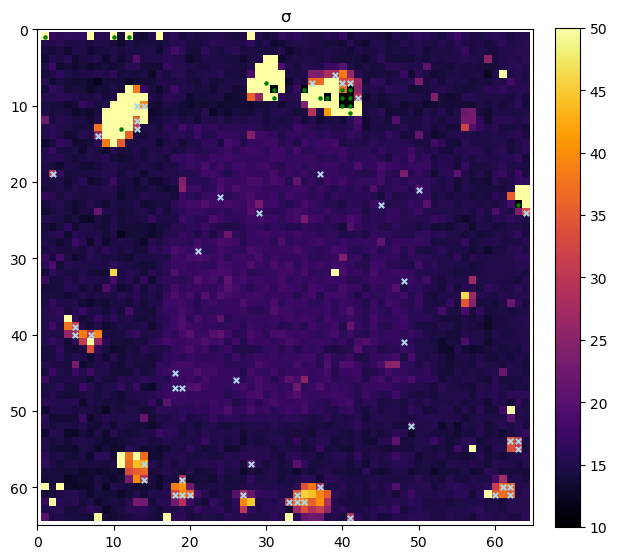

PyObject <matplotlib.collections.PathCollection object at 0x7fbbc80a1320>

In [73]:
figure(figsize=(7,7))
xlim(0,65)
ylim(65,0)
title("σ")
limites=50
imagen=imshow(DesviacionPorCanal, origin="lower", interpolation="nearest",cmap="inferno", 
                      vmin=10,vmax=limites, extent=[0.5,64.5,0.5,64.5])
cb=colorbar(fraction=0.046, pad=0.04)

x=[]
y=[]
for j in 1:size(PruebaRespuesta)[1]
  append!(x,PruebaRespuesta[j,2])
   append!(y,PruebaRespuesta[j,1])
end


x2=[]
y2=[]
for j in 1:size(Saturados)[1]
  append!(x2,Saturados[j,2])
   append!(y2,Saturados[j,1])
end


scatter(x,y, marker="x",c="lightblue", s=15)
scatter(x2,y2, marker="o",c="green", s=5)

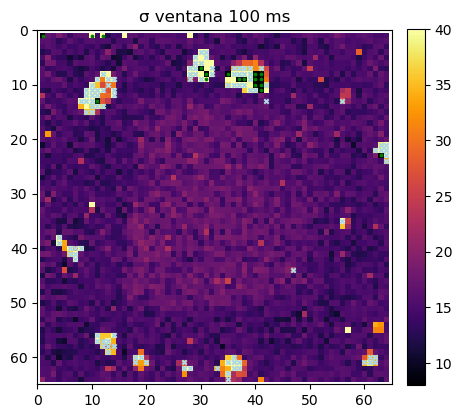

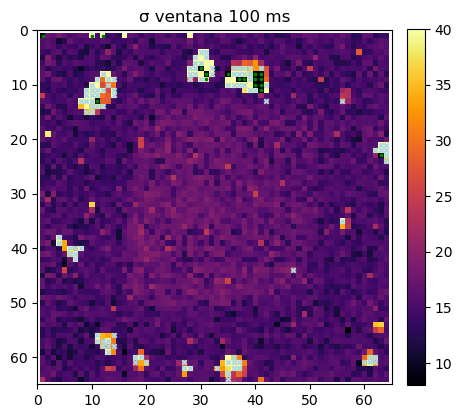

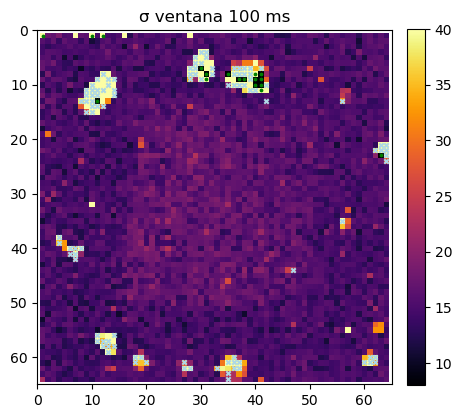

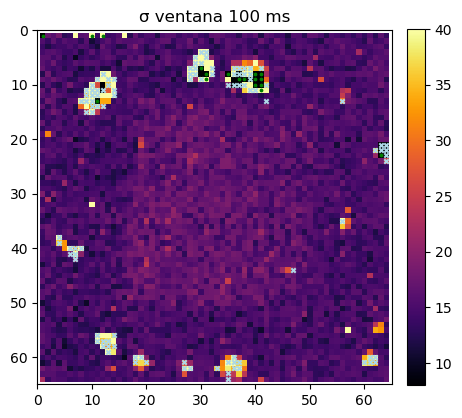

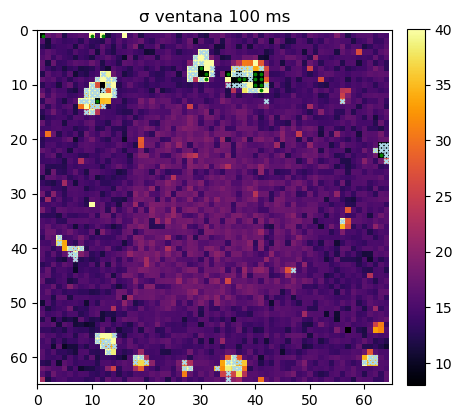

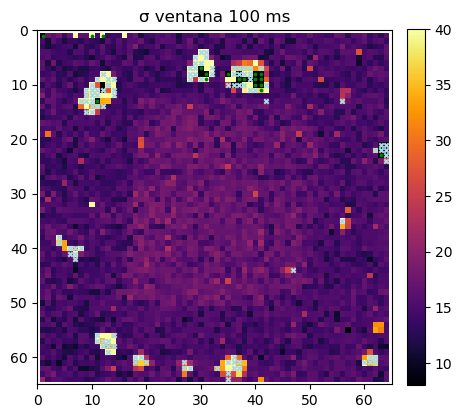

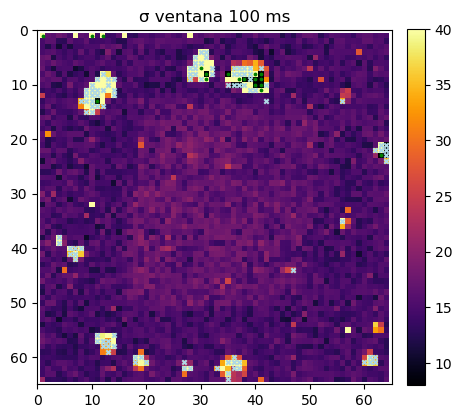

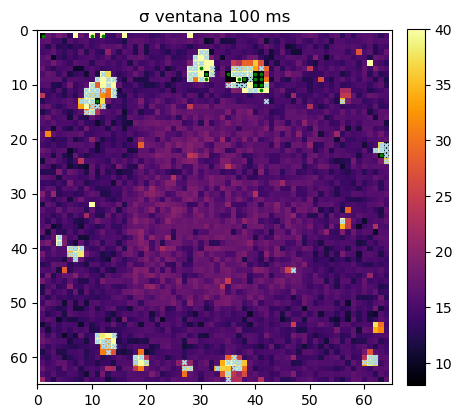

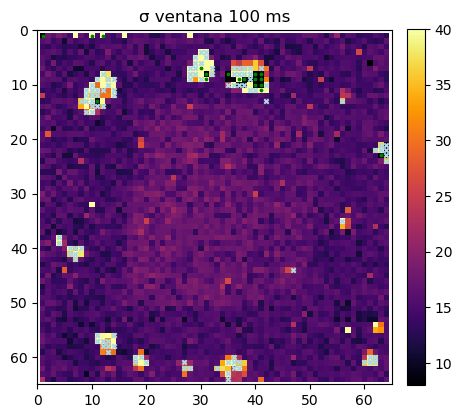

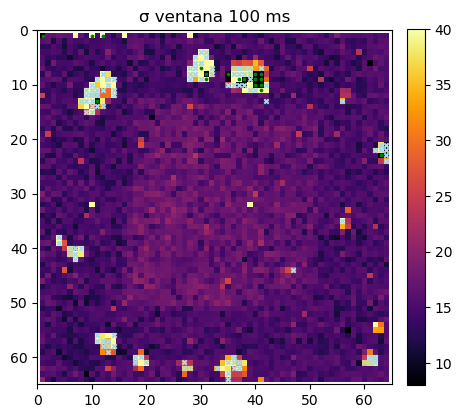

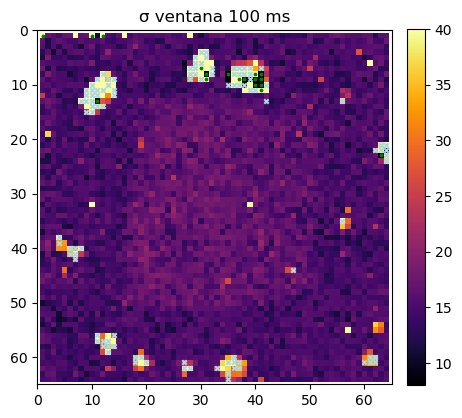

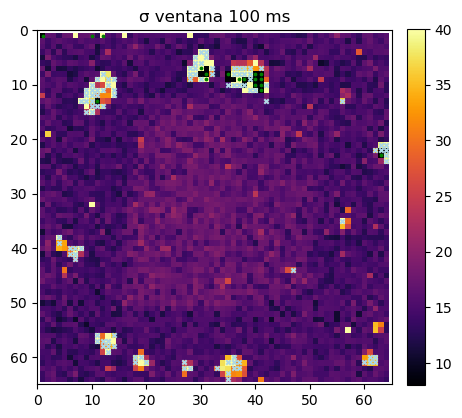

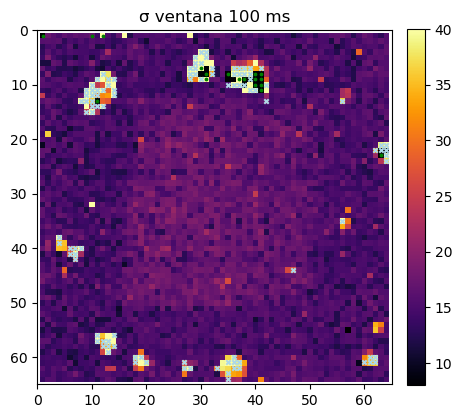

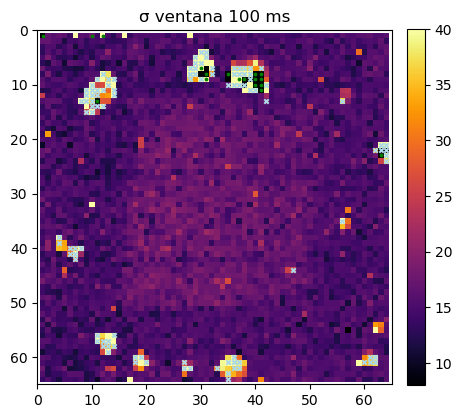

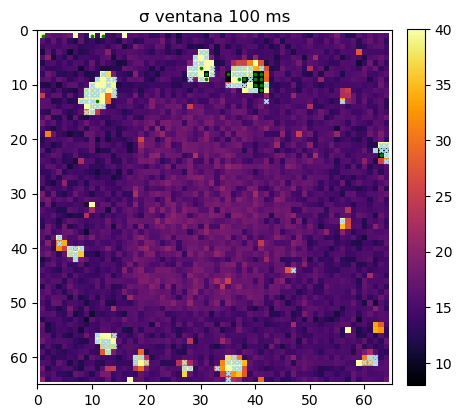

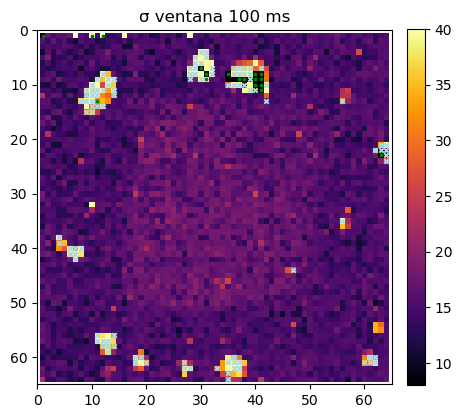

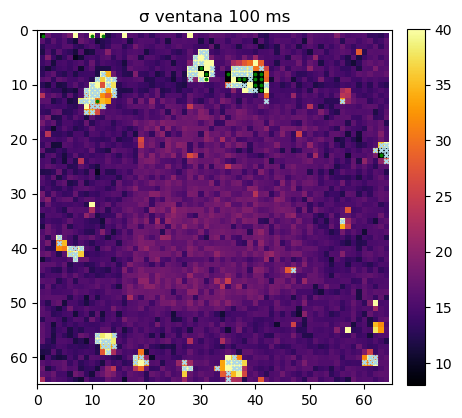

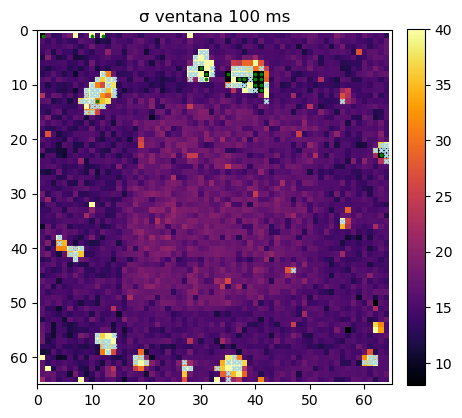

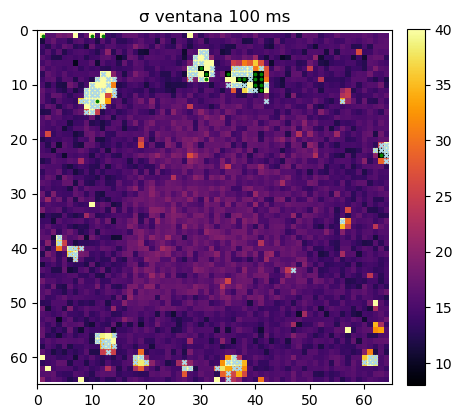

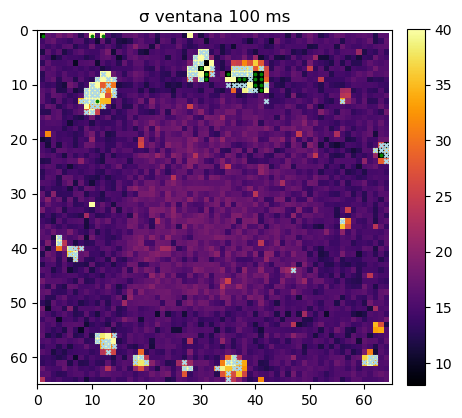

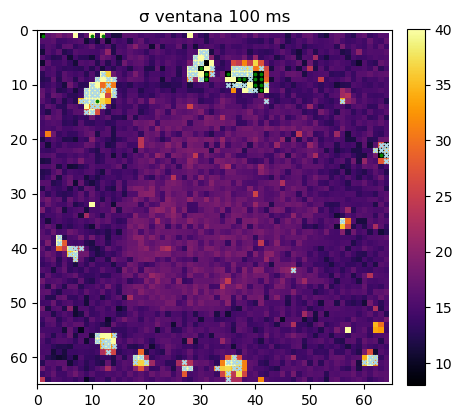

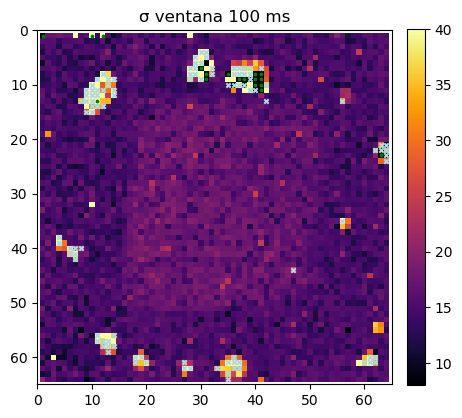

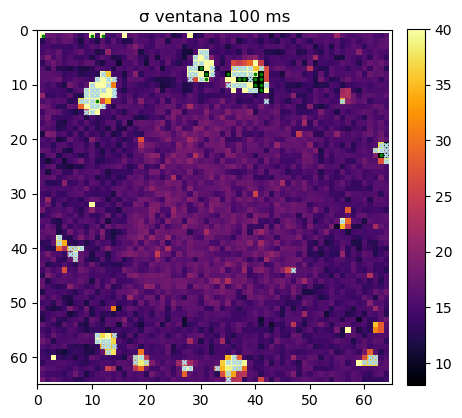

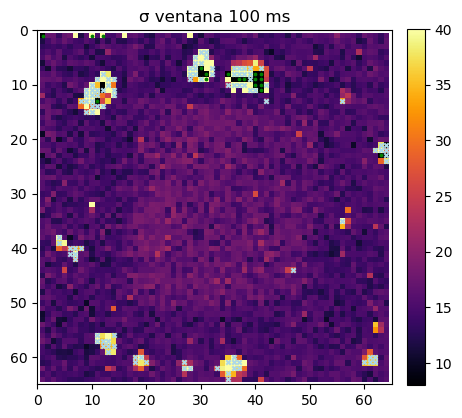

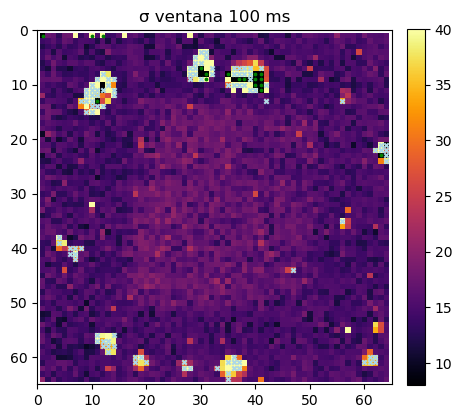

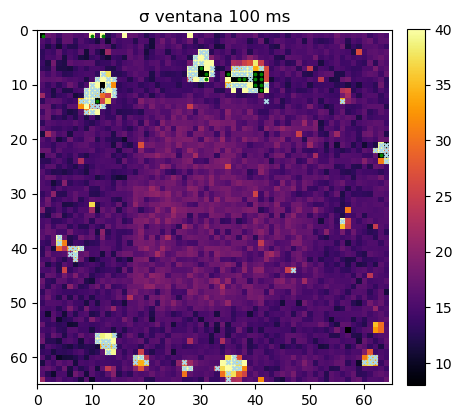

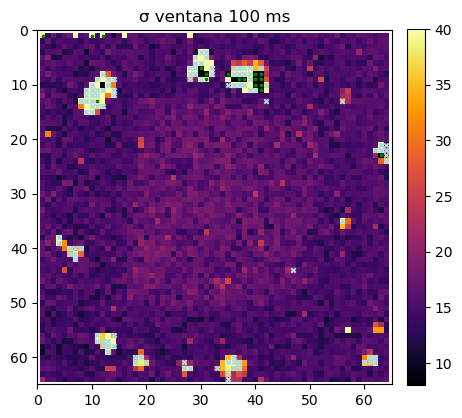

In [48]:
ioff()
for n=1:nmax

 ioff()   
figure(figsize=(5,5))
xlim(0,65)
ylim(65,0)
title("σ ventana 100 ms")
limites=40
datos=sigmaventanas[:,:,n]
imagen=imshow(datos, origin="lower", interpolation="nearest",cmap="inferno", 
                      vmin=8,vmax=limites, extent=[0.5,64.5,0.5,64.5])
cb=colorbar(fraction=0.046, pad=0.04)

x=[]
y=[]
for j in 1:size(PruebaRespuesta)[1]
  append!(x,PruebaRespuesta[j,2])
   append!(y,PruebaRespuesta[j,1])
end


x2=[]
y2=[]
for j in 1:size(Saturados)[1]
  append!(x2,Saturados[j,2])
   append!(y2,Saturados[j,1])
end


scatter(x,y, marker="x",c="lightblue", s=10)
scatter(x2,y2, marker="o",c="green", s=3)
    
#outnmame="SigmaEstriado_Cacho_1_$n.png"    
#savefig(outnmame, dpi=90)    
    #close()
end

Escogamos uno de los que parecen estar en la "sombra luminosa" del Cuerno de Amon y que estén marcados con x blanca.

In [ ]:
egtrazo=DatosCentrados[10,37,:];

In [ ]:
egtrazo[29000:34000];

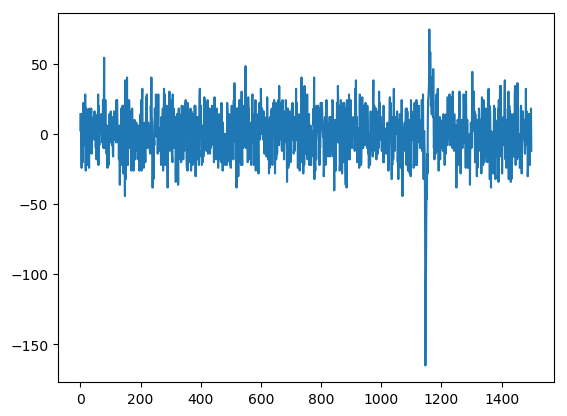

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fba859e5400>

In [60]:
plot(DatosCentrados[33,48,1:1500])

In [61]:
std(DatosCentrados[33,48,1:1500])

16.96050594267118

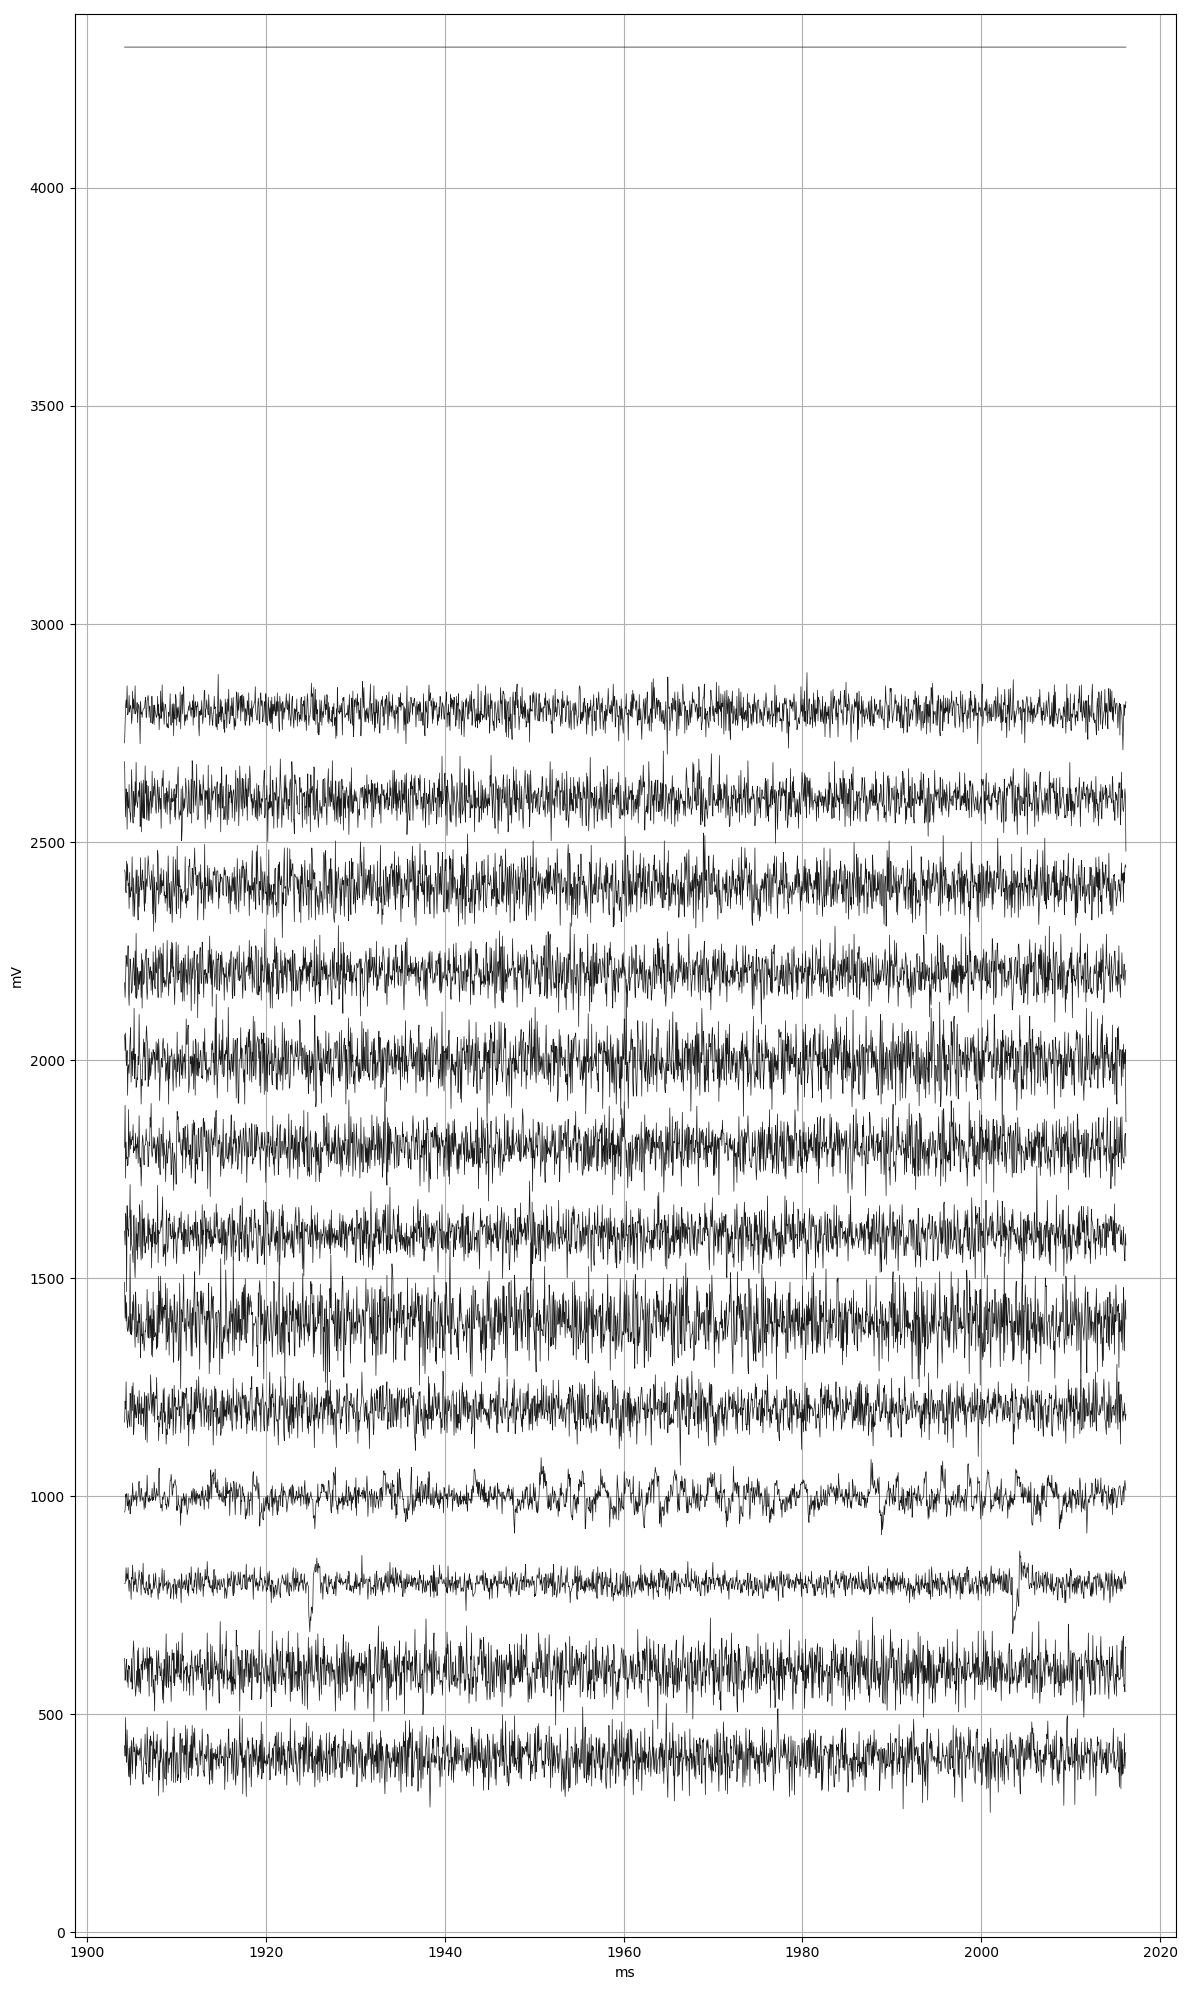

In [50]:
figure(figsize=(12,20))
xlabel("ms")
ylabel("mV")
ylim(-10,4400)

desde=34000
hasta=36000
#intervalo=1:cacho
intervalo=desde:hasta
intert=intervalo./(freq)


for j in 85:100
  l=PruebaRespuesta[j,1]
  k=PruebaRespuesta[j,2]
  egtrazo=DatosCentrados[l,k,intervalo].+(j-84)*200
    
    plot(intert,egtrazo, lw=0.5, c="100070")
end

bu=[1776,1796]
ba=[0,0]

bru=[1796,1796]
bra=[0,200]

#plot(bu,ba, lw=3, c="black")
#plot(bru,bra, lw=3, c="black")


#annotate("20ms", xy=(1780,20), fontsize=14)
#annotate("200mV", xy=(1797,140), fontsize=14, rotation=90)

#axis("off")
grid()

tight_layout()
#savefig("TrazosEjemploEstriado04.png", dpi=92)
#close()

Tomaremos el intervalo interesante y guardaremos esos datos en un archivo con toda la información de saturados y respuestas, 
de la misma forma que como se hace con los evocados. A diferencia de éstos, no tenemos parámetros de latencia, en lugar de eso
tendremos una indicacion de "de donde a donde se cortaron los datos", en cuadros.

In [ ]:
PruebaRespuesta[93,:]

In [ ]:
dirname(stringgeneral), basename(stringgeneral)

In [ ]:
dirgen=dirname(stringgeneral)
basegen=basename(stringgeneral)
#una palabra para indicar el intervalo 
outname=string(dirgen,palabritaespecial, basegen, "tuebule.h5")
#aqui hay que arreglar el rollo del directorio

listaaguardar=Dict(
    "LFPSaturados" => DatosCentrados[:,:,desde:hasta],
     "desde" => desde,
    "hasta" => hasta,
     "freq" =>freq,
     "Canalesrespuesta" => PruebaRespuesta,
     "CanalesSaturados" => Saturados)

println(outname )
   h5open(outname, "w")  do file
        for k in keys(listaaguardar)
            datos=listaaguardar[k]
            println("abriendo los datos ", k)
            println
            write(file, "$k", datos)
        end
    end

println("hemos guardado este cacho en el archivo ", outname)

In [ ]:
typeof(listaaguardar)

In [ ]:
figure(figsize=(12,10))


rango=6000:8500
trazoejemplo=DatosCentrados[33,48,rango]

plot(rango,trazoejemplo,lw=0.2)